# Analyzing authorship of tweets from Rihanna and Katy Perry using Gemini


In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import pickle
import pandas as pd
import numpy as np
import time
from random import sample


from credentials import get_credentials_gemini
API_KEY = get_credentials_gemini()
os.environ["GEMINI_API_KEY"] = API_KEY

import google.generativeai as genai


genai.configure(api_key=os.getenv("GEMINI_API_KEY"))


In [2]:
# Load training data
with open('./data/sampled_author_texts.pkl', 'rb') as f:
    training_data = pickle.load(f)

# Load test data
with open('./data/twitter_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [3]:
# Helper functions

def get_training_sample(training_data, n_samples=15):
    rihanna_tweets = training_data['rihanna'].split('\n')
    katy_tweets = training_data['katyperry'].split('\n')
    rihanna_sample = sample([t for t in rihanna_tweets if t.strip()], n_samples)
    katy_sample = sample([t for t in katy_tweets if t.strip()], n_samples)
    return {
        'rihanna': '\n'.join(rihanna_sample),
        'katyperry': '\n'.join(katy_sample)
    }

def normalize_author_name(name):
    name = name.lower().strip()
    if name in ['katy perry', 'katyperry', 'katy']:
        return 'katyperry'
    if name in ['rihanna', 'riri']:
        return 'rihanna'
    return name

def get_completion(prompt: str, model: str = "gemini-2.0-flash") -> str:
    '''
    Generate a completion for a given prompt using the Gemini API
    Args:
        prompt: The prompt to generate a completion for
        model: The model to use for the completion
    Returns:
        The completion for the prompt
    '''
    model = genai.GenerativeModel(model)
    response = model.generate_content(prompt)
    return response.text

In [4]:
n_samples = 100
sampled_tweets = test_data.sample(n=n_samples, random_state=42).reset_index(drop=True)
print(f"Created sample dataset with {len(sampled_tweets)} tweets")
print("\nSample distribution:")
print(sampled_tweets['author'].value_counts())

Created sample dataset with 100 tweets

Sample distribution:
author
rihanna      56
katyperry    44
Name: count, dtype: int64


In [5]:
# Run predictions 

batch_size = 10
total_batches = len(sampled_tweets) // batch_size + (1 if len(sampled_tweets) % batch_size > 0 else 0)
results = []
errors = []

print(f"Starting processing of {len(sampled_tweets)} tweets in {total_batches} batches")

for batch in range(total_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(sampled_tweets))
    batch_training_data = get_training_sample(training_data)
    batch_errors = 0

    for idx in range(start_idx, end_idx):
        row = sampled_tweets.iloc[idx]
        tweet_text = row['content']
        actual_author = normalize_author_name(row['author'])

        prompt = f"""
You are an expert in linguistic analysis and authorship attribution. Your task is to analyze authorship--i.e. idiolectal--markers that the texts reveal about their authors.

You will be provided with:
1. Training samples (tweets) from 2 different authors, Rihanna and Katy Perry
2. A new text whose author you need to identify between those two authors

Guideline for analysis:
- Just use state of the art techniques to attribute authorship

Rihanna's tweets:
{batch_training_data['rihanna']}

Katy Perry's tweets:
{batch_training_data['katyperry']}

New text to analyze:
{tweet_text}

Your answer should contain only the author's name and nothing else.
"""
        max_retries = 3
        retry_delay = 60 

        for retry in range(max_retries):
            try:
                raw_prediction = get_completion(prompt).strip()
                prediction = normalize_author_name(raw_prediction)
                if prediction in ['rihanna', 'katyperry']:
                    results.append((idx, tweet_text, actual_author, prediction))
                else:
                    batch_errors += 1
                    errors.append((idx, f"Invalid prediction: {raw_prediction}"))
                time.sleep(5)  # 5 second delay between tweets
                break
            except Exception as e:
                if retry < max_retries - 1:
                    time.sleep(retry_delay)
                else:
                    batch_errors += 1
                    errors.append((idx, str(e)))
                    break

    print(f"Completed batch {batch + 1}/{total_batches} (tweets {start_idx}-{end_idx-1})")
    if batch_errors > 0:
        print(f"  ⚠️  {batch_errors} errors in this batch")
    if batch < total_batches - 1:
        print("  Taking a 30 second break...")
        time.sleep(30)

print("\nProcessing complete!")
print(f"Successfully processed: {len(results)} tweets")
if errors:
    print(f"Total errors: {len(errors)}")

Starting processing of 100 tweets in 10 batches
Completed batch 1/10 (tweets 0-9)
  Taking a 30 second break...
Completed batch 2/10 (tweets 10-19)
  Taking a 30 second break...
Completed batch 3/10 (tweets 20-29)
  Taking a 30 second break...
Completed batch 4/10 (tweets 30-39)
  Taking a 30 second break...
Completed batch 5/10 (tweets 40-49)
  Taking a 30 second break...
Completed batch 6/10 (tweets 50-59)
  Taking a 30 second break...
Completed batch 7/10 (tweets 60-69)
  Taking a 30 second break...
Completed batch 8/10 (tweets 70-79)
  Taking a 30 second break...
Completed batch 9/10 (tweets 80-89)
  Taking a 30 second break...
Completed batch 10/10 (tweets 90-99)

Processing complete!
Successfully processed: 100 tweets


Overall accuracy: 88.00% (88/100)
Accuracy for rihanna: 89.29% (50/56)
Accuracy for katyperry: 86.36% (38/44)


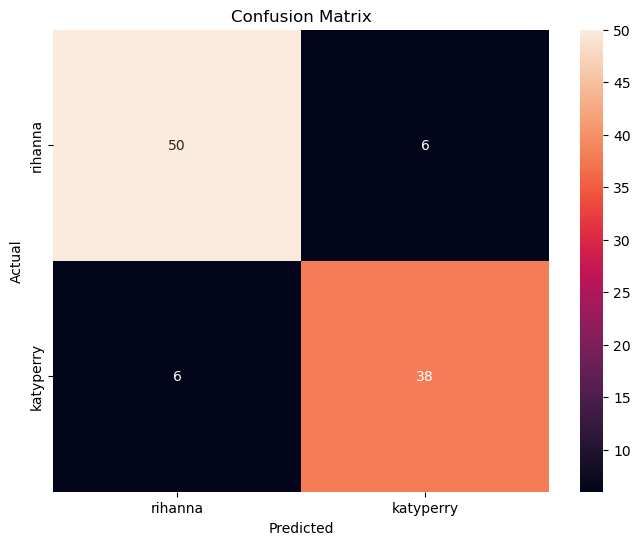

In [6]:
# Analyze results

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

results_df = pd.DataFrame(results, columns=['idx', 'tweet_text', 'actual_author', 'predicted_author'])

# Accuracy
correct = (results_df['actual_author'] == results_df['predicted_author']).sum()
total = len(results_df)
print(f"Overall accuracy: {correct/total:.2%} ({correct}/{total})")

# Per-author accuracy
for author in ['rihanna', 'katyperry']:
    author_cases = results_df[results_df['actual_author'] == author]
    if not author_cases.empty:
        acc = (author_cases['actual_author'] == author_cases['predicted_author']).mean()
        print(f"Accuracy for {author}: {acc:.2%} ({(author_cases['actual_author'] == author_cases['predicted_author']).sum()}/{len(author_cases)})")

# Confusion matrix
cm = confusion_matrix(results_df['actual_author'], results_df['predicted_author'], labels=['rihanna', 'katyperry'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['rihanna', 'katyperry'], yticklabels=['rihanna', 'katyperry'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
# Find correct and incorrect predictions
correct_cases = results_df[results_df['actual_author'] == results_df['predicted_author']]
incorrect_cases = results_df[results_df['actual_author'] != results_df['predicted_author']]

# Sample a few from each
n_samples = 5
sampled_correct = correct_cases.sample(n=min(n_samples, len(correct_cases)), random_state=42)
sampled_incorrect = incorrect_cases.sample(n=min(n_samples, len(incorrect_cases)), random_state=42)

print("SOME CORRECTLY CLASSIFIED EXAMPLES:\n")
for _, row in sampled_correct.iterrows():
    print(f"Tweet: {row['tweet_text']}\nActual: {row['actual_author']} | Predicted: {row['predicted_author']}\n{'-'*60}")

print("\nSOME INCORRECTLY CLASSIFIED EXAMPLES:\n")
for _, row in sampled_incorrect.iterrows():
    print(f"Tweet: {row['tweet_text']}\nActual: {row['actual_author']} | Predicted: {row['predicted_author']}\n{'-'*60}")

SOME CORRECTLY CLASSIFIED EXAMPLES:

Tweet: #NYFW #AdamSellman http://t.co/IdD71W3mW0
Actual: rihanna | Predicted: rihanna
------------------------------------------------------------
Tweet: It's just beyond the vault. Discover room 7 of the #ANTIdiaRy at https://t.co/uJ0CLlhoaS https://t.co/povYOBn3Fm
Actual: rihanna | Predicted: rihanna
------------------------------------------------------------
Tweet: She. x Shoot day x Inez and Vinoodh http://t.co/1lZLyYVzV5
Actual: rihanna | Predicted: rihanna
------------------------------------------------------------
Tweet: 👼🏻 luminary fairy 👼🏻 @ Burning Man https://t.co/N2ENwLknBt
Actual: katyperry | Predicted: katyperry
------------------------------------------------------------
Tweet: TODAY'S THE DAY! Take home an even BIGGER #PartofMe on DVD/BluRay! Bonus footage: more songs, more jokes, more GRANDMA! http://t.co/W2g1iviy
Actual: katyperry | Predicted: katyperry
------------------------------------------------------------

SOME INCORRECTL

In [9]:
# Save as HTML for easy human reading
qualitative_df = pd.concat([
    sampled_correct.assign(case='correct'),
    sampled_incorrect.assign(case='incorrect')
])
qualitative_df.to_html("./data/gemini_qualitative_analysis.html", index=False)
print("Saved qualitative inspection to gemini_qualitative_analysis.html")

Saved qualitative inspection to gemini_qualitative_analysis.html


In [10]:
# Ask Gemini to explain the results

prompt = f"""
A Large Language Model was tasked with attributing authorship to tweets from Rihanna and Katy Perry.
Generally, the model performed well, with close to 90% accuracy. However, it made some mistakes.

You will be provided with:
1. A list of tweets from Rihanna and Katy Perry that were correctly classified by the model
2. A list of tweets from Rihanna and Katy Perry that were incorrectly classified by the model

Your task and guidelines:
Act as a linguistic expert. Your task is to explain the performance of the model. Think globally about the dataset and the discursive patterns that emerge. Give more focus/
in trying to understand the mistakes the model made.
Do not focus on individual tweets, but rather on the broader discursive patterns. Try, when possible, to use examples to illustrate those patterns.

Here are the tweets from Rihanna and Katy Perry that were correctly classified by the model:
<correct_cases>
{correct_cases['tweet_text'].to_string(index=False)}
</correct_cases>

Here are the tweets from Rihanna and Katy Perry that were incorrectly classified by the model:
<incorrect_cases>
{incorrect_cases['tweet_text'].to_string(index=False)}
</incorrect_cases>

Your answer should be a two to three paragraph explanation about the performance of the model, following the guidelines above.
"""

In [11]:
from IPython.display import display, HTML

qualitative_explanation = get_completion(prompt)
display(HTML(qualitative_explanation))
